# Koopman learning
### Author: Uday Kiran Reddy Tadipatri

## Part 1: Generating custom non-linear ODEs

Consider $m$ finite points in $\mathbb{R}^d$ represented by $\{x_j\}_{j \in [m]}$. We are intrested in obtaining a nonlinear ODE such these points are fixed / stable points. Stability in nonlinear system typically means in the sense of
Lyapunov. We now introduce Lyapunov theory, first of
which includes
Lypunov function candidate $V: \mathbb{R}^+ \times \mathbb{R}^{d} \to \mathbb{R}$ (c.f. Chapter 5, Vidysagar' 02 *by my UG advisor* 🙃) such that: \
(i) $V(t, z) \geq 0$ for all $t \geq 0$, $z \in \mathbb{R}^d$, \
(ii) $V(t, z) = 0 \iff z = 0$, and \
(iii) all sub-level sets of $V(t, \cdot)$ are bounded.

Lyapunov function is Lypunov function candidate with an
additional property that $\dot{V}(t,z) \leq 0$ for all $z \in \mathbb{R}^d$. The following statements hold true for a non-linear ODE $\dot{x} = f(x)$
with 0 as stable point: \
(a) **Global boundedness**: If such a Lyapunov function exists, then all the trajectories $x(t)$ are bounded. \
(b) **Global asymptotic stability**: If Lyapunov function is such that $\dot{V}(t, z) < 0$ for all $z \neq 0$, then $\lim_{t \to \infty}x(t) = 0$. \
(b') **Converse Lyapunov theory**: If the system has a stable point, then there exists a non-trivial region (known as region of attraction) for which Lyapunov function exists.
(c) **Global exponential stability**: If Lyapunov function is such that for some $\alpha > 0$ $\dot{V}(t, z) < -\alpha V(t, z)$ , then for some $a, b > 0$ we have that $\|x(t)\| \leq be^{-at/2}\|{x(0)}\|$.

By now it should be convincing, proposing a Lyapunov function candidate is important. Consider the candidate $V(t, z) = \|z\|_2^2\prod_{j\in[m]}\exp(-\|z - x_j\|_2^2$) for a ODE $\dot{x} = -\nabla_{x} V(t, x)$. Now let's perform Lyapunov stability analysis

(i, ii, iii) By construction, this holds true.\
(b) $\dot{V}(t, z) = -\|\nabla V(t, z)\|_2^2 < 0$, except for the stable point and $0$.

Therefore, the chosen non-linear ODE indeed has
asymptotic stable points at $\{x_j\}_{j \in [m]}$. The below is the routine generated by ChatGPT to verify this in 2D space.

Stable points:  [array([-1, -1]), array([ 1, -1]), array([-1,  1]), array([1., 1.]), array([0, 0]), array([-1, -2]), array([ 1, -2]), array([-1,  2]), array([1, 2]), array([-2, -1]), array([ 2, -1]), array([-2,  1]), array([2, 1])]
Globally Exponentially stable points


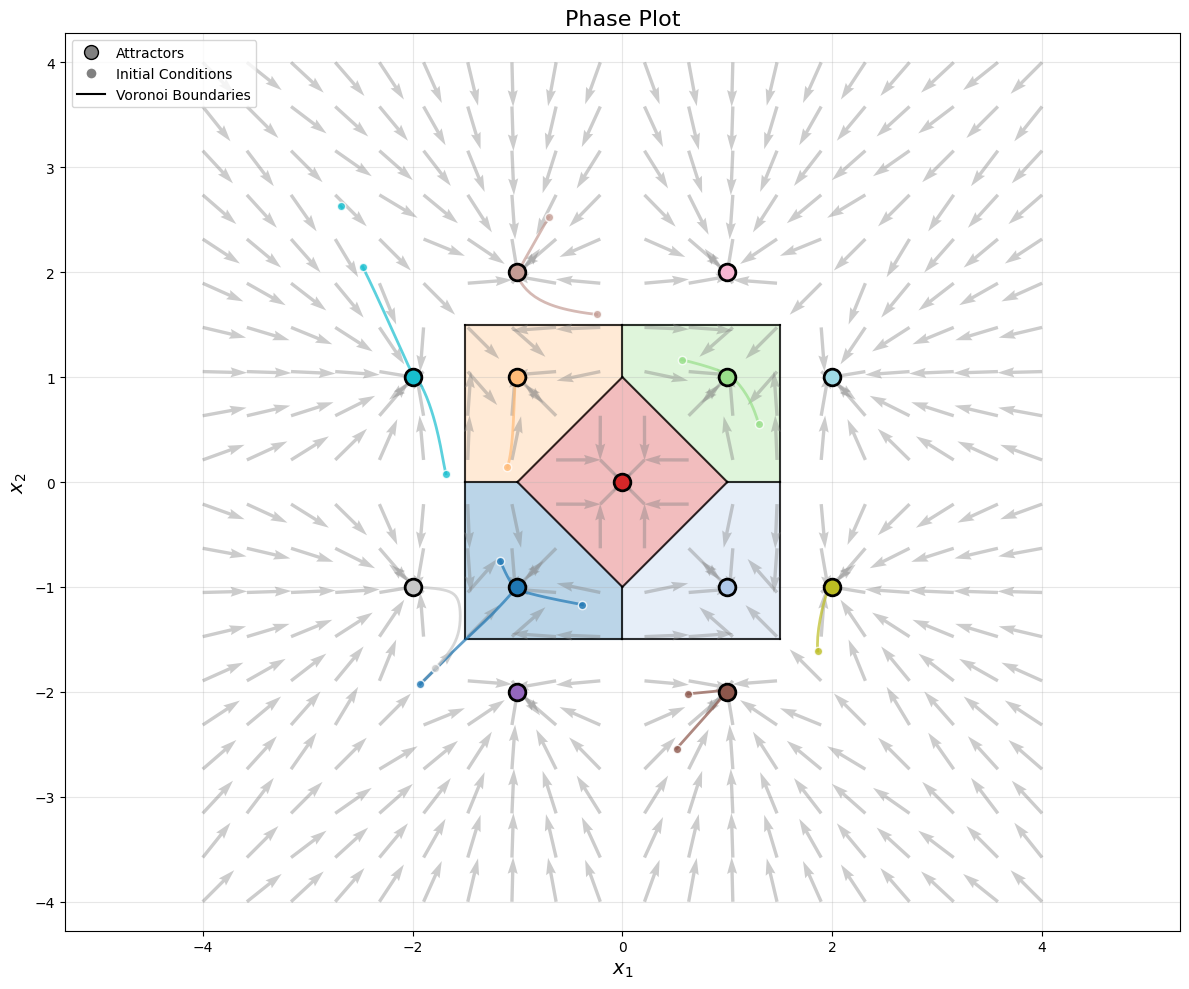

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# ---------------- system construction -----------------
def dynamics_ges(x, points, sigma = 0.5):
	"""
	Nonlinear system with exponentially stable equilibria
	at specified points.
	x : np.array, shape (2,)
	points : list of np.array, equilibria
	W : list of 2x2 matrices (positive definite), one per point
	sigma : width parameter for bump functions
	"""
	dx = np.zeros(2)
	for i, p in enumerate(points):
		diff = x - p
		psi = (np.linalg.norm(x) ** 2) * np.exp(-np.linalg.norm(diff)**2 / sigma ** 2)
		dx -= 2 * diff * psi / sigma ** 2
	for i, p in enumerate(points):
		diff = x - p
		psi = np.exp(-np.linalg.norm(diff)**2 / sigma ** 2)
		dx -= diff * psi
	return dx

# ---------------- simulation -----------------
def simulate(x0, points, T=10.0, dt=0.01, dynamics=dynamics_ges):
	"""
	Forward Euler simulation.
	"""
	traj = [x0]
	x = x0.copy()
	steps = int(T / dt)
	for _ in range(steps):
		dx = dynamics(x, points)
		x = x + dt * dx
		traj.append(x.copy())
	return np.array(traj)

# ---------------- plotting with Voronoi -----------------
def plot_phase_with_voronoi(points, dynamics):
	# Convert points to array format for Voronoi
	points_array = np.array([p for p in points])

	# Create Voronoi diagram
	vor = Voronoi(points_array)

	# Create figure
	plt.figure(figsize=(12,10))

	# Generate distinct colors for each point/region
	import matplotlib.cm as cm
	colors = cm.tab20(np.linspace(0, 1, len(points)))  # Use tab20 colormap for distinct colors

	# Plot finite Voronoi regions with colors
	for i, point_idx in enumerate(vor.point_region):
		region = vor.regions[point_idx]
		if not region or -1 in region:
			continue
		# Get vertices of the region
		vertices = np.array([vor.vertices[j] for j in region])
		if len(vertices) > 0:
			# Plot filled region
			plt.fill(vertices[:, 0], vertices[:, 1], color=colors[i], alpha=0.3, zorder=1)

	# Plot Voronoi edges
	for simplex in vor.ridge_vertices:
		simplex = np.asarray(simplex)
		if np.all(simplex >= 0):
			plt.plot(vor.vertices[simplex, 0], vor.vertices[simplex, 1], 'k-', linewidth=1.5, alpha=0.8, zorder=2)

	# Grid for vector field
	X, Y = np.meshgrid(np.linspace(-4, 4, 20),
	                   np.linspace(-4, 4, 20))
	U, V = np.zeros_like(X), np.zeros_like(Y)
	for i in range(X.shape[0]):
		for j in range(X.shape[1]):
			dx = dynamics(np.array([X[i,j], Y[i,j]]), points)
			U[i,j], V[i,j] = dx[0], dx[1]

	# Normalize arrows
	N = np.sqrt(U**2 + V**2)
	N = np.where(N == 0, 1, N)  # Avoid division by zero
	U, V = U/N, V/N

	# Plot vector field
	plt.quiver(X, Y, U, V, color='gray', alpha=0.4, scale=25, zorder=3)

	# Plot equilibria with matching colors
	for i, p in enumerate(points):
		plt.plot(p[0], p[1], 'o', color=colors[i], markersize=12,
				markeredgecolor='black', markeredgewidth=2, zorder=6, label=f'Point {i+1}' if i < 5 else "")

	# Simulate from random initial conditions with color-coded trajectories
	np.random.seed(42)  # For reproducible results
	for _ in range(15):
		x0 = np.random.uniform(-2.8, 2.8, size=2)
		traj = simulate(x0, points, dynamics=dynamics, T=15.0)

		# Find which point the trajectory converges to (closest to final position)
		final_pos = traj[-1]
		distances = [np.linalg.norm(final_pos - p) for p in points]
		closest_point_idx = np.argmin(distances)

		# Plot trajectory with matching color
		plt.plot(traj[:,0], traj[:,1], color=colors[closest_point_idx],
				lw=2, alpha=0.7, zorder=4)
		# Mark initial condition
		plt.plot(x0[0], x0[1], 'o', color=colors[closest_point_idx],
				markersize=6, alpha=0.8, markeredgecolor='white', markeredgewidth=1, zorder=5)

	plt.xlim(-3, 3)
	plt.ylim(-3, 3)
	plt.xlabel('$x_1$', fontsize=14)
	plt.ylabel('$x_2$', fontsize=14)
	plt.title('Phase Plot', fontsize=16)
	plt.grid(True, alpha=0.3)
	plt.axis('equal')

	# Add simplified legend
	from matplotlib.lines import Line2D
	legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
							 markeredgecolor='black', markersize=10, label='Attractors'),
	                  Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
							 markeredgecolor='white', markersize=8, label='Initial Conditions'),
	                  Line2D([0], [0], color='black', linewidth=1.5, label='Voronoi Boundaries')]
	plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))

	plt.tight_layout()
	plt.show()


# ---------------- alternative plotting function -----------------
def plot_phase(points, dynamics):
	"""Original plotting function without Voronoi"""
	# Grid for vector field
	X, Y = np.meshgrid(np.linspace(-3, 3, 25),
	                   np.linspace(-3, 3, 25))
	U, V = np.zeros_like(X), np.zeros_like(Y)
	for i in range(X.shape[0]):
		for j in range(X.shape[1]):
			dx = dynamics(np.array([X[i,j], Y[i,j]]), points)
			U[i,j], V[i,j] = dx[0], dx[1]
	# Normalize arrows
	N = np.sqrt(U**2 + V**2)
	N = np.where(N == 0, 1, N)  # Avoid division by zero
	U, V = U/N, V/N
	# Plot vector field
	plt.figure(figsize=(8,8))
	plt.quiver(X, Y, U, V, color='gray', alpha=0.7)
	# Plot equilibria
	for p in points:
		plt.plot(p[0], p[1], 'ro', markersize=8)
	# Simulate from random initial conditions
	for _ in range(20):
		x0 = np.random.uniform(-3, 3, size=2)
		traj = simulate(x0, points, dynamics=dynamics)
		plt.plot(traj[:,0], traj[:,1], lw=1.5, alpha=0.5)
	plt.xlabel('$x_1$')
	plt.ylabel('$x_2$')
	plt.title('Phase plot of proposed ODE')
	plt.axis('equal')
	plt.show()

# ---------------- main execution -----------------
points = [np.array([-1, -1]), np.array([1, -1]), np.array([-1, 1]), np.array([1.0, 1.0]), np.array([0, 0]),
          np.array([-1, -2]), np.array([1, -2]), np.array([-1, 2]), np.array([1, 2]),
		  np.array([-2, -1]), np.array([2, -1]), np.array([-2, 1]), np.array([2, 1])]

print("Stable points: ", points)
print("Globally Exponentially stable points")

# Plot with Voronoi regions
plot_phase_with_voronoi(points, dynamics_ges)

# Uncomment below to also show original plot without Voronoi
# plot_phase(points, dynamics_ges)

Using device: cpu
NEURAL ODE ENCODER-DECODER LEARNING
Generating 10 trajectories...


Generating data: 100%|██████████| 10/10 [00:00<00:00, 478.82trajectory/s]


Generating 3 trajectories...


Generating data: 100%|██████████| 3/3 [00:00<00:00, 370.96trajectory/s]



Model Summary:
- Total parameters: 7,844
- Trainable parameters: 7,844
- State dimension: 4
- Latent dimension: 16
- Diagonal dynamics matrix shape: torch.Size([16, 16])
- Training trajectories: 10
- Test trajectories: 3

Starting training on cpu...


Training:   0%|          | 1/500 [00:00<04:51,  1.71epoch/s, Total Loss=0.158800, Recon=0.106688, Pred=0.104222]

Epoch 0: Total Loss = 0.158800, Recon = 0.106688, Pred = 0.104222


Training:  20%|██        | 101/500 [01:02<03:55,  1.69epoch/s, Total Loss=0.001819, Recon=0.001217, Pred=0.001204]

Epoch 100: Total Loss = 0.001819, Recon = 0.001217, Pred = 0.001204


Training:  40%|████      | 201/500 [02:04<03:03,  1.63epoch/s, Total Loss=0.000353, Recon=0.000246, Pred=0.000215]

Epoch 200: Total Loss = 0.000353, Recon = 0.000246, Pred = 0.000215


Training:  60%|██████    | 301/500 [03:06<01:57,  1.69epoch/s, Total Loss=0.000200, Recon=0.000133, Pred=0.000134]

Epoch 300: Total Loss = 0.000200, Recon = 0.000133, Pred = 0.000134


Training:  80%|████████  | 401/500 [04:08<01:01,  1.60epoch/s, Total Loss=0.000448, Recon=0.000304, Pred=0.000288]

Epoch 400: Total Loss = 0.000448, Recon = 0.000304, Pred = 0.000288


Training: 100%|██████████| 500/500 [05:09<00:00,  1.61epoch/s, Total Loss=0.000507, Recon=0.000341, Pred=0.000331]



Evaluating on test data...


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 53.86trajectory/s]



Test Results:
- Total Loss: 0.044872
- Reconstruction Loss: 0.030678
- Prediction Loss: 0.028387

Plotting training curves...


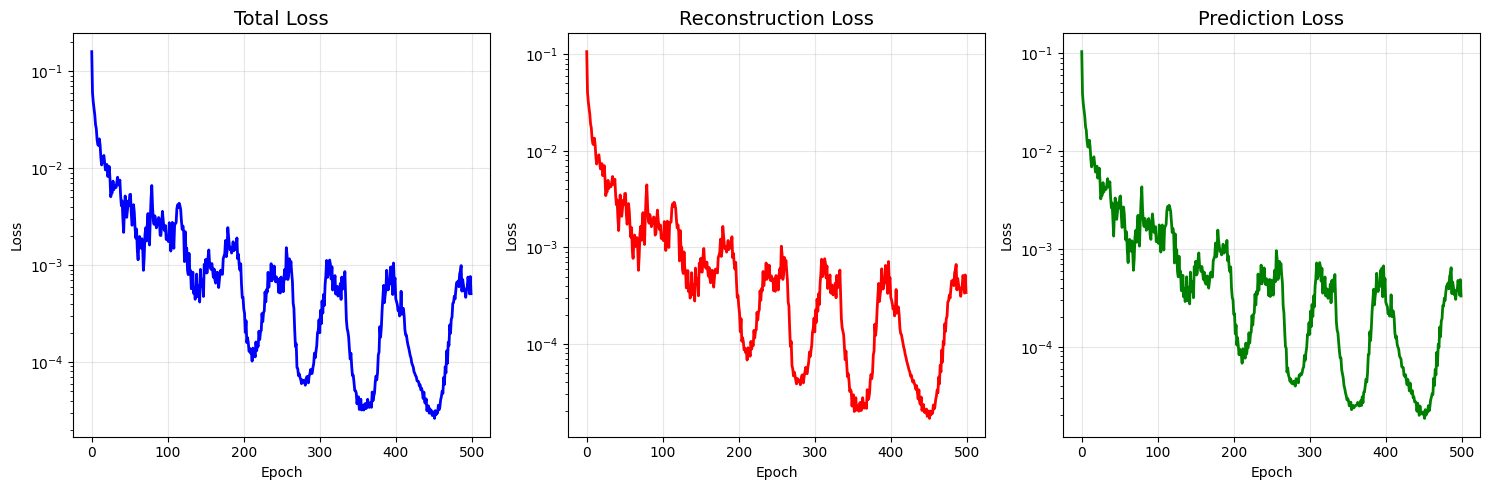


Learned dynamics matrix K (diagonal):
[[0.966551   0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.93549347 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.98223495 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.9274523  0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.981936   0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.91745263
  0.         0.         0.         0.         0.         0

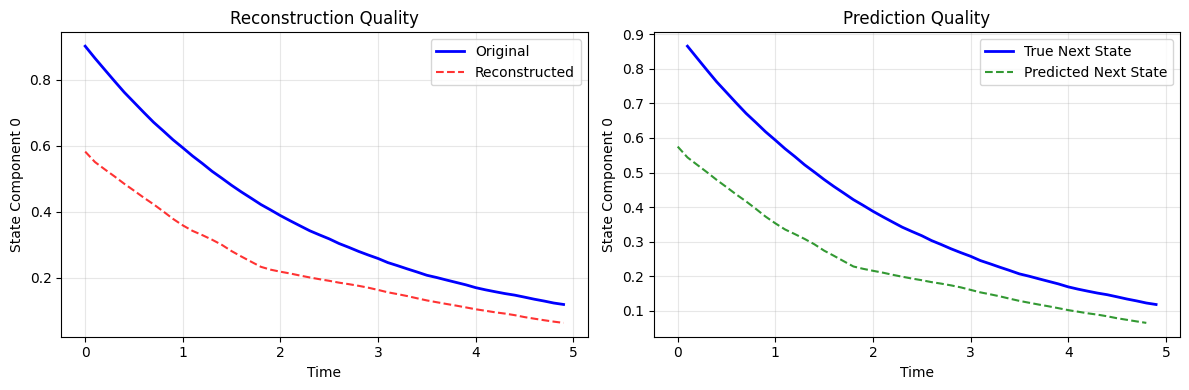


TRAINING COMPLETED SUCCESSFULLY!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from typing import Tuple, List
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")

class TimeEncoder(nn.Module):
    """Time-dependent encoder E(t, x_t) -> z_t"""
    def __init__(self, input_dim: int, latent_dim: int, hidden_dims: List[int] = [64, 32]):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Time embedding
        self.time_embed = nn.Linear(1, 16)

        # Main network layers
        layers = []
        prev_dim = input_dim + 16  # concatenate time embedding
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.LayerNorm(hidden_dim)
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, latent_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            t: Time tensor of shape (batch_size, 1) or (1,) or scalar
            x: State tensor of shape (batch_size, input_dim)
        Returns:
            z: Latent representation of shape (batch_size, latent_dim)
        """
        batch_size = x.shape[0]

        # Ensure t has proper shape (batch_size, 1)
        if t.dim() == 0:  # scalar time
            t = t.unsqueeze(0).unsqueeze(0).expand(batch_size, 1)
        elif t.dim() == 1:  # 1D tensor
            if t.shape[0] == 1:
                t = t.unsqueeze(0).expand(batch_size, 1)
            else:
                t = t.unsqueeze(1)  # (batch_size,) -> (batch_size, 1)
        elif t.shape[0] == 1 and batch_size > 1:
            t = t.expand(batch_size, 1)

        # Ensure t is on same device as x
        t = t.to(x.device)

        t_embed = torch.relu(self.time_embed(t))
        x_with_t = torch.cat([x, t_embed], dim=1)
        return self.network(x_with_t)

class TimeDecoder(nn.Module):
    """Time-dependent decoder D(t, z_t) -> x_t"""
    def __init__(self, latent_dim: int, output_dim: int, hidden_dims: List[int] = [32, 64]):
        super().__init__()
        self.latent_dim = latent_dim
        self.output_dim = output_dim

        # Time embedding
        self.time_embed = nn.Linear(1, 16)

        # Main network layers
        layers = []
        prev_dim = latent_dim + 16  # concatenate time embedding
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.LayerNorm(hidden_dim)
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """
        Args:
            t: Time tensor of shape (batch_size, 1) or (1,) or scalar
            z: Latent tensor of shape (batch_size, latent_dim)
        Returns:
            x: Reconstructed state of shape (batch_size, output_dim)
        """
        batch_size = z.shape[0]

        # Ensure t has proper shape (batch_size, 1)
        if t.dim() == 0:  # scalar time
            t = t.unsqueeze(0).unsqueeze(0).expand(batch_size, 1)
        elif t.dim() == 1:  # 1D tensor
            if t.shape[0] == 1:
                t = t.unsqueeze(0).expand(batch_size, 1)
            else:
                t = t.unsqueeze(1)  # (batch_size,) -> (batch_size, 1)
        elif t.shape[0] == 1 and batch_size > 1:
            t = t.expand(batch_size, 1)

        # Ensure t is on same device as z
        t = t.to(z.device)

        t_embed = torch.relu(self.time_embed(t))
        z_with_t = torch.cat([z, t_embed], dim=1)
        return self.network(z_with_t)

class LatentDynamics(nn.Module):
    """Diagonal matrix K for latent space dynamics"""
    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim
        # Initialize as identity for stability
        self.log_diagonal = nn.Parameter(torch.zeros(latent_dim))

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """Apply diagonal dynamics matrix K to latent state z"""
        diagonal = torch.exp(self.log_diagonal)  # Ensure positive values
        return z * diagonal

    @property
    def K_matrix(self) -> torch.Tensor:
        """Get the diagonal matrix K"""
        diagonal = torch.exp(self.log_diagonal)
        return torch.diag(diagonal)

class NeuralODESystem(nn.Module):
    """Complete system with encoder, decoder, and latent dynamics"""
    def __init__(self, state_dim: int, latent_dim: int,
                 encoder_hidden: List[int] = [64, 32],
                 decoder_hidden: List[int] = [32, 64]):
        super().__init__()
        self.state_dim = state_dim
        self.latent_dim = latent_dim

        self.encoder = TimeEncoder(state_dim, latent_dim, encoder_hidden)
        self.decoder = TimeDecoder(latent_dim, state_dim, decoder_hidden)
        self.dynamics = LatentDynamics(latent_dim)

    def encode(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(t, x)

    def decode(self, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        return self.decoder(t, z)

    def predict_next(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """Predict x_{t+1} through latent dynamics"""
        z_t = self.encode(t, x)
        z_next = self.dynamics(z_t)
        x_next = self.decode(t, z_next)  # Note: using same time t
        return x_next

def compute_loss(model: NeuralODESystem,
                 times: torch.Tensor,
                 states: torch.Tensor,
                 alpha1: float = 1.0,
                 alpha2: float = 1.0) -> Tuple[torch.Tensor, dict]:
    """
    Compute the loss function from your problem formulation

    Args:
        model: The neural ODE system
        times: Tensor of shape (T,) - time points
        states: Tensor of shape (T, batch_size, state_dim) - trajectory data
        alpha1: Weight for reconstruction loss
        alpha2: Weight for prediction loss

    Returns:
        total_loss: Scalar tensor
        loss_dict: Dictionary with loss components
    """
    T = len(times)
    batch_size = states.shape[1]

    reconstruction_loss = 0.0
    prediction_loss = 0.0

    for i in range(T):
        t = times[i]  # Scalar time value
        x_t = states[i]  # Shape: (batch_size, state_dim)

        # Encode current state
        z_t = model.encode(t, x_t)

        # Reconstruction loss: ||x_t - D(t, z_t)||²
        x_recon = model.decode(t, z_t)
        reconstruction_loss += torch.mean((x_t - x_recon) ** 2)

        # Prediction loss: ||x_{t+1} - D(t, K*z_t)||² (if not last timestep)
        if i < T - 1:
            x_next_true = states[i + 1]

            # Apply dynamics in latent space
            z_next_pred = model.dynamics(z_t)
            x_next_pred = model.decode(t, z_next_pred)

            prediction_loss += torch.mean((x_next_true - x_next_pred) ** 2)

    # Average over time steps
    reconstruction_loss /= T
    prediction_loss /= (T - 1) if T > 1 else 1

    total_loss = alpha1 * reconstruction_loss + alpha2 * prediction_loss

    return total_loss, {
        'total': total_loss.item(),
        'reconstruction': reconstruction_loss.item(),
        'prediction': prediction_loss.item()
    }

def train_model(model: NeuralODESystem,
                train_data: List[Tuple[torch.Tensor, torch.Tensor]],
                num_epochs: int = 1000,
                learning_rate: float = 1e-3,
                alpha1: float = 1.0,
                alpha2: float = 1.0,
                device: str = 'cuda') -> List[dict]:
    """
    Train the neural ODE system

    Args:
        model: The model to train
        train_data: List of (times, states) tuples for different trajectories
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        alpha1: Weight for reconstruction loss
        alpha2: Weight for prediction loss
        device: Device to train on ('cuda' or 'cpu')

    Returns:
        loss_history: List of loss dictionaries for each epoch
    """
    # Move model to device
    model = model.to(device)

    # Move data to device
    train_data_device = []
    for times, states in train_data:
        train_data_device.append((times.to(device), states.to(device)))

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.8)#, verbose=True)

    loss_history = []

    # Training loop with progress bar
    pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")

    for epoch in pbar:
        epoch_losses = []

        # Process each trajectory
        for times, states in train_data_device:
            optimizer.zero_grad()

            loss, loss_dict = compute_loss(model, times, states, alpha1, alpha2)
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            epoch_losses.append(loss_dict)

        # Average losses over all trajectories
        avg_losses = {
            'total': np.mean([l['total'] for l in epoch_losses]),
            'reconstruction': np.mean([l['reconstruction'] for l in epoch_losses]),
            'prediction': np.mean([l['prediction'] for l in epoch_losses])
        }

        scheduler.step(avg_losses['total'])
        loss_history.append(avg_losses)

        # Update progress bar
        pbar.set_postfix({
            'Total Loss': f"{avg_losses['total']:.6f}",
            'Recon': f"{avg_losses['reconstruction']:.6f}",
            'Pred': f"{avg_losses['prediction']:.6f}"
        })

        # Log every 100 epochs
        if epoch % 100 == 0:
            tqdm.write(f"Epoch {epoch}: Total Loss = {avg_losses['total']:.6f}, "
                      f"Recon = {avg_losses['reconstruction']:.6f}, "
                      f"Pred = {avg_losses['prediction']:.6f}")

    pbar.close()
    return loss_history

def generate_example_data(num_trajectories: int = 10,
                         T: int = 50,
                         state_dim: int = 4,
                         dt: float = 0.1,
                         device: str = 'cuda') -> List[Tuple[torch.Tensor, torch.Tensor]]:
    """Generate example trajectory data for testing"""
    trajectories = []

    print(f"Generating {num_trajectories} trajectories...")

    for _ in tqdm(range(num_trajectories), desc="Generating data", unit="trajectory"):
        times = torch.linspace(0, (T-1)*dt, T)

        # Generate a simple nonlinear dynamical system
        states = torch.zeros(T, 1, state_dim)  # (T, batch_size=1, state_dim)
        states[0, 0] = torch.randn(state_dim) * 0.5  # Random initial condition

        for t in range(1, T):
            # Simple nonlinear dynamics for demonstration
            x = states[t-1, 0]
            # dx/dt = -0.5*x + 0.1*sin(x) + noise
            dx = -0.5 * x + 0.1 * torch.sin(x) + 0.01 * torch.randn(state_dim)
            states[t, 0] = x + dt * dx

        trajectories.append((times.to(device), states.to(device)))

    return trajectories

def evaluate_model(model: NeuralODESystem,
                   test_data: List[Tuple[torch.Tensor, torch.Tensor]],
                   alpha1: float = 1.0,
                   alpha2: float = 1.0) -> dict:
    """Evaluate the model on test data"""
    model.eval()

    test_losses = []

    with torch.no_grad():
        for times, states in tqdm(test_data, desc="Evaluating", unit="trajectory"):
            loss, loss_dict = compute_loss(model, times, states, alpha1, alpha2)
            test_losses.append(loss_dict)

    # Average losses over all test trajectories
    avg_test_losses = {
        'total': np.mean([l['total'] for l in test_losses]),
        'reconstruction': np.mean([l['reconstruction'] for l in test_losses]),
        'prediction': np.mean([l['prediction'] for l in test_losses])
    }

    return avg_test_losses

def visualize_reconstruction(model: NeuralODESystem,
                           trajectory: Tuple[torch.Tensor, torch.Tensor],
                           component_idx: int = 0):
    """Visualize reconstruction for one trajectory component"""
    model.eval()

    times, states = trajectory
    T = len(times)

    original = []
    reconstructed = []
    predicted = []

    with torch.no_grad():
        for i in range(T):
            t = times[i]
            x_t = states[i]

            # Encode and decode
            z_t = model.encode(t, x_t)
            x_recon = model.decode(t, z_t)

            original.append(x_t[0, component_idx].cpu().item())
            reconstructed.append(x_recon[0, component_idx].cpu().item())

            # Prediction (if not last timestep)
            if i < T - 1:
                z_next_pred = model.dynamics(z_t)
                x_next_pred = model.decode(t, z_next_pred)
                predicted.append(x_next_pred[0, component_idx].cpu().item())
            else:
                predicted.append(None)

    # Plotting
    times_cpu = times.cpu().numpy()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(times_cpu, original, 'b-', label='Original', linewidth=2)
    plt.plot(times_cpu, reconstructed, 'r--', label='Reconstructed', alpha=0.8)
    plt.xlabel('Time')
    plt.ylabel(f'State Component {component_idx}')
    plt.title('Reconstruction Quality')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(times_cpu[1:], [original[i+1] for i in range(T-1)], 'b-',
             label='True Next State', linewidth=2)
    plt.plot(times_cpu[:-1], [p for p in predicted[:-1]], 'g--',
             label='Predicted Next State', alpha=0.8)
    plt.xlabel('Time')
    plt.ylabel(f'State Component {component_idx}')
    plt.title('Prediction Quality')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Set random seed for reproducibility
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    # Suppress warnings
    warnings.filterwarnings('ignore', category=UserWarning)

    # Parameters
    state_dim = 4
    latent_dim = 16
    num_train_trajectories = 10
    num_test_trajectories = 3

    # Generate example data
    print("=" * 50)
    print("NEURAL ODE ENCODER-DECODER LEARNING")
    print("=" * 50)

    train_data = generate_example_data(
        num_trajectories=num_train_trajectories,
        T=50,
        state_dim=state_dim,
        device=device
    )

    test_data = generate_example_data(
        num_trajectories=num_test_trajectories,
        T=50,
        state_dim=state_dim,
        device=device
    )

    # Create model
    model = NeuralODESystem(state_dim=state_dim, latent_dim=latent_dim)
    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nModel Summary:")
    print(f"- Total parameters: {total_params:,}")
    print(f"- Trainable parameters: {trainable_params:,}")
    print(f"- State dimension: {state_dim}")
    print(f"- Latent dimension: {latent_dim}")
    print(f"- Diagonal dynamics matrix shape: {model.dynamics.K_matrix.shape}")
    print(f"- Training trajectories: {num_train_trajectories}")
    print(f"- Test trajectories: {num_test_trajectories}")

    # Train model
    print(f"\nStarting training on {device}...")
    loss_history = train_model(
        model, train_data,
        num_epochs=500,
        learning_rate=1e-3,
        alpha1=1.0,
        alpha2=0.5,
        device=device
    )

    # Evaluate on test data
    print("\nEvaluating on test data...")
    test_results = evaluate_model(model, test_data, alpha1=1.0, alpha2=0.5)

    print(f"\nTest Results:")
    print(f"- Total Loss: {test_results['total']:.6f}")
    print(f"- Reconstruction Loss: {test_results['reconstruction']:.6f}")
    print(f"- Prediction Loss: {test_results['prediction']:.6f}")

    # Plot training curves
    print("\nPlotting training curves...")
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot([l['total'] for l in loss_history], 'b-', linewidth=2)
    plt.title('Total Loss', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot([l['reconstruction'] for l in loss_history], 'r-', linewidth=2)
    plt.title('Reconstruction Loss', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.plot([l['prediction'] for l in loss_history], 'g-', linewidth=2)
    plt.title('Prediction Loss', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Show learned dynamics matrix
    print(f"\nLearned dynamics matrix K (diagonal):")
    K_matrix = model.dynamics.K_matrix.detach().cpu().numpy()
    print(K_matrix)
    print(f"Diagonal elements: {np.diag(K_matrix)}")

    # Visualize reconstruction for first test trajectory
    print("\nVisualizing reconstruction for first test trajectory...")
    visualize_reconstruction(model, test_data[0], component_idx=0)

    print("\n" + "=" * 50)
    print("TRAINING COMPLETED SUCCESSFULLY!")
    print("=" * 50)

Using device: cuda
GPU: Tesla T4
NEURAL ODE LEARNING FOR MULTI-ATTRACTOR SYSTEM
Stable points: 13 equilibria
System: Globally Exponentially Stable Multi-Attractor Dynamics
Generating 25 trajectories from true system...


Generating data: 100%|██████████| 25/25 [00:00<00:00, 49.79trajectory/s]



Model Summary:
- Total parameters: 26,018
- State dimension: 2
- Latent dimension: 16
- Training trajectories: 25
- Time steps per trajectory: 80

Starting training on cuda...


Training:   1%|          | 1/100 [00:08<13:57,  8.46s/epoch, Total Loss=2.280349, Recon=1.344145, Pred=1.337435]

Epoch 0: Total Loss = 2.280349, Recon = 1.344145, Pred = 1.337435


Training: 100%|██████████| 100/100 [13:34<00:00,  8.14s/epoch, Total Loss=0.024205, Recon=0.013976, Pred=0.014613]



Plotting training curves...


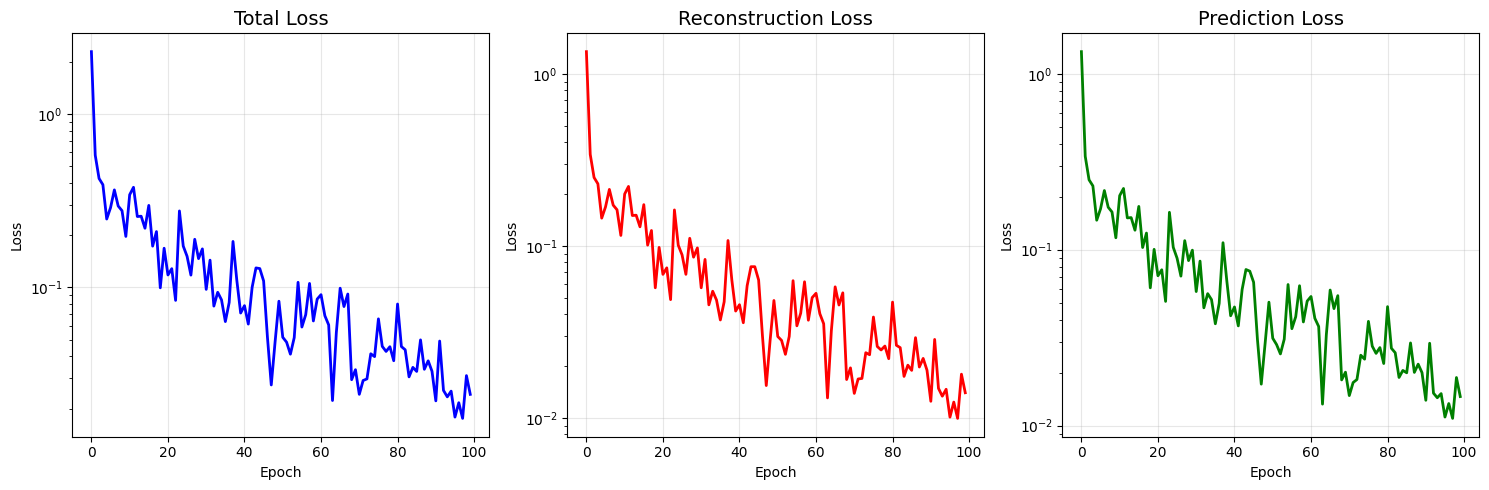


Learned dynamics matrix K (diagonal):
Diagonal elements: [1.0381955  1.0069776  1.0458914  1.0357782  1.0321273  1.0177875
 0.98525095 1.0478296  1.0335491  0.95587397 0.98642355 1.0423827
 1.0508417  1.0677242  1.0123601  1.0069505 ]

Generating phase portrait comparison...


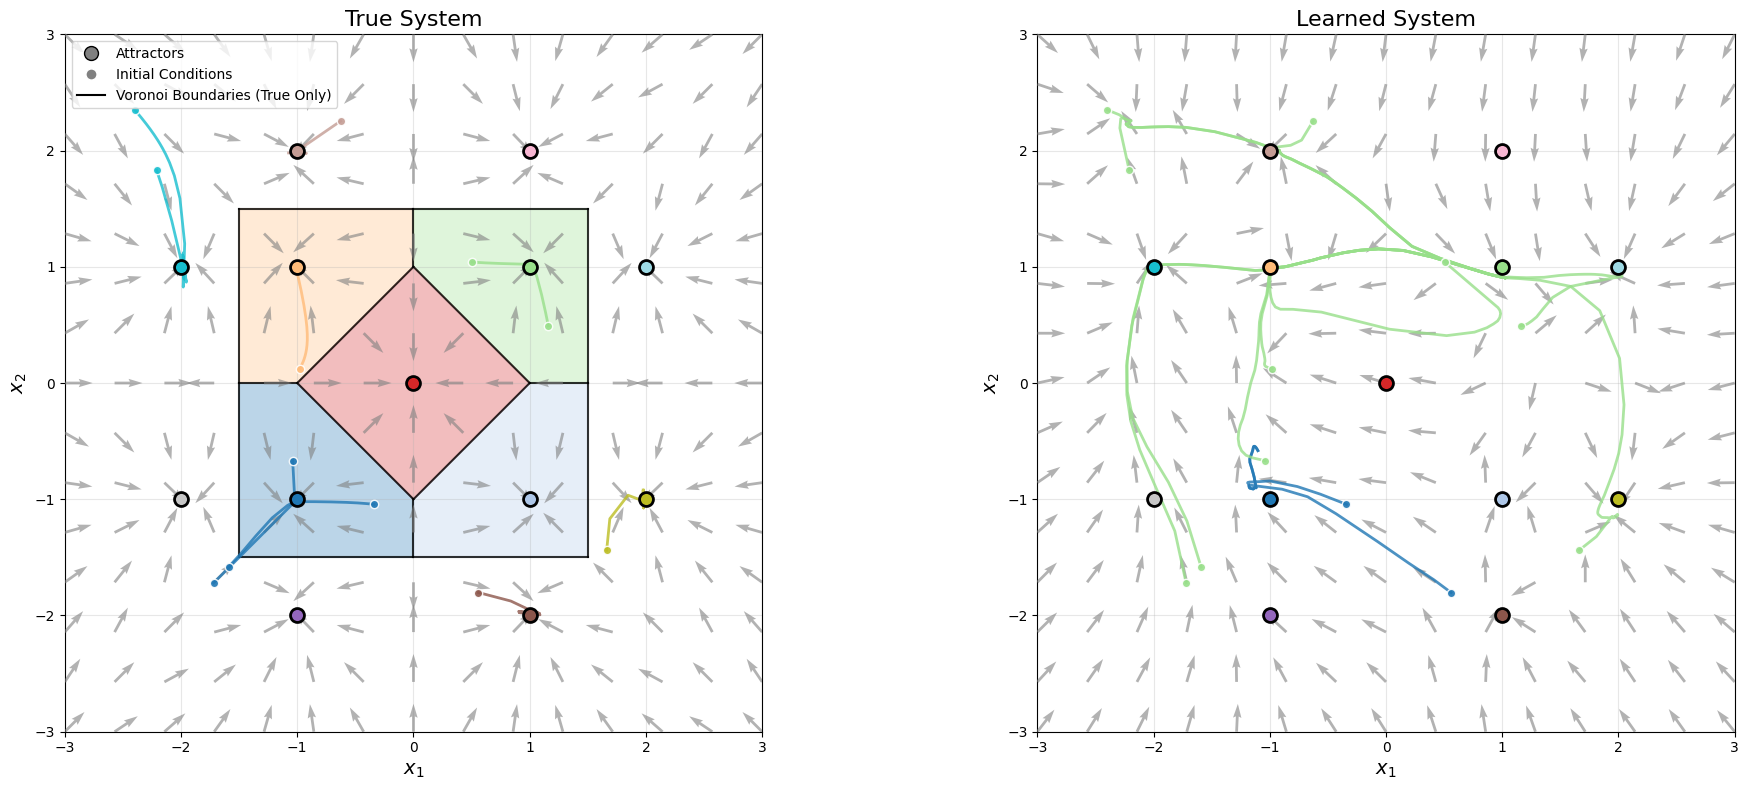


Testing trajectory comparison...


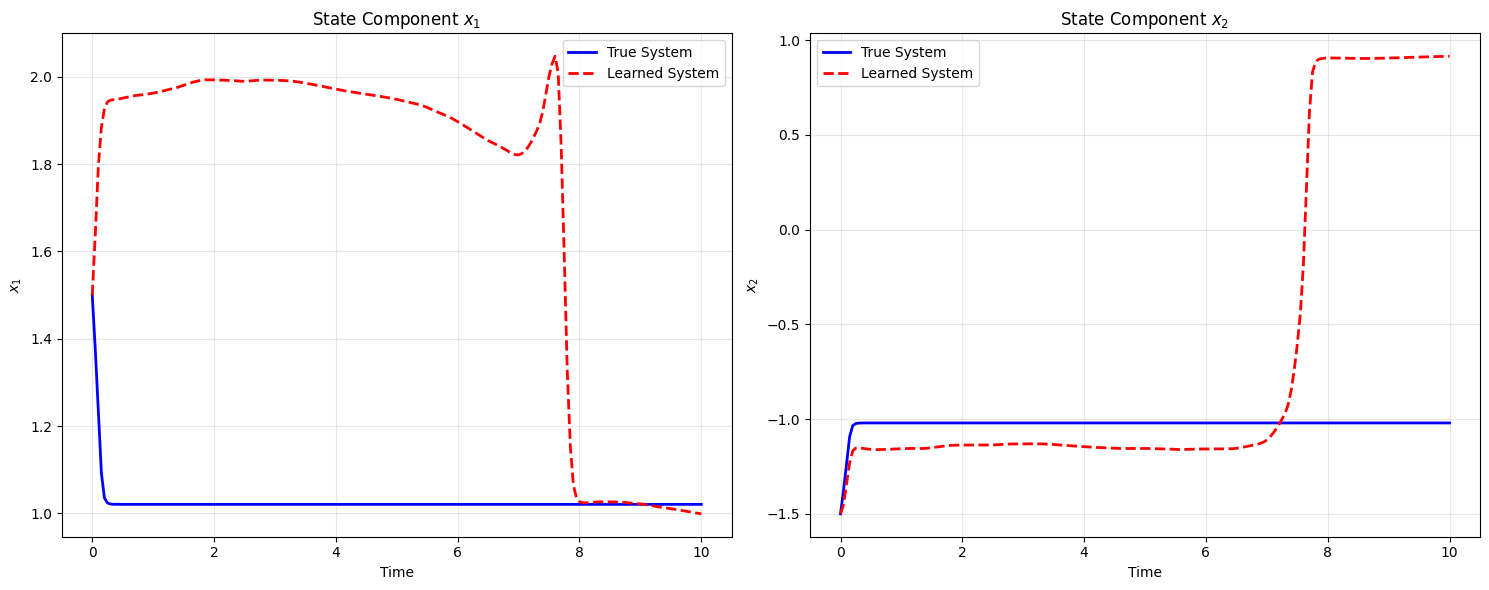


Trajectory Comparison (Initial condition: [ 1.5 -1.5]):
- MSE Error: 0.770179
- Max Absolute Error: 1.935057

LEARNING COMPLETED SUCCESSFULLY!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from typing import Tuple, List
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
from scipy.spatial import Voronoi, voronoi_plot_2d

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")

# ---------------- Original Dynamical System -----------------
def dynamics_ges(x, points, sigma=0.5):
    """
    Nonlinear system with exponentially stable equilibria
    at specified points.
    x : np.array, shape (2,)
    points : list of np.array, equilibria
    sigma : width parameter for bump functions
    """
    dx = np.zeros(2)
    for i, p in enumerate(points):
        diff = x - p
        psi = (np.linalg.norm(x) ** 2) * np.exp(-np.linalg.norm(diff)**2 / sigma ** 2)
        dx -= 2 * diff * psi / sigma ** 2
    for i, p in enumerate(points):
        diff = x - p
        psi = np.exp(-np.linalg.norm(diff)**2 / sigma ** 2)
        dx -= diff * psi
    return dx

def simulate_true_system(x0, points, T=10.0, dt=0.01):
    """Forward Euler simulation of the true system."""
    traj = [x0]
    x = x0.copy()
    steps = int(T / dt)
    for _ in range(steps):
        dx = dynamics_ges(x, points)
        x = x + dt * dx
        traj.append(x.copy())
    return np.array(traj)

# ---------------- Neural ODE Components -----------------
class TimeEncoder(nn.Module):
    """Time-dependent encoder E(t, x_t) -> z_t"""
    def __init__(self, input_dim: int, latent_dim: int, hidden_dims: List[int] = [64, 32]):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Time embedding
        self.time_embed = nn.Linear(1, 16)

        # Main network layers
        layers = []
        prev_dim = input_dim + 16  # concatenate time embedding
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.LayerNorm(hidden_dim)
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, latent_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]

        # Ensure t has proper shape (batch_size, 1)
        if t.dim() == 0:  # scalar time
            t = t.unsqueeze(0).unsqueeze(0).expand(batch_size, 1)
        elif t.dim() == 1:  # 1D tensor
            if t.shape[0] == 1:
                t = t.unsqueeze(0).expand(batch_size, 1)
            else:
                t = t.unsqueeze(1)  # (batch_size,) -> (batch_size, 1)
        elif t.shape[0] == 1 and batch_size > 1:
            t = t.expand(batch_size, 1)

        # Ensure t is on same device as x
        t = t.to(x.device)

        t_embed = torch.relu(self.time_embed(t))
        x_with_t = torch.cat([x, t_embed], dim=1)
        return self.network(x_with_t)

class TimeDecoder(nn.Module):
    """Time-dependent decoder D(t, z_t) -> x_t"""
    def __init__(self, latent_dim: int, output_dim: int, hidden_dims: List[int] = [32, 64]):
        super().__init__()
        self.latent_dim = latent_dim
        self.output_dim = output_dim

        # Time embedding
        self.time_embed = nn.Linear(1, 16)

        # Main network layers
        layers = []
        prev_dim = latent_dim + 16  # concatenate time embedding
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.LayerNorm(hidden_dim)
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        batch_size = z.shape[0]

        # Ensure t has proper shape (batch_size, 1)
        if t.dim() == 0:  # scalar time
            t = t.unsqueeze(0).unsqueeze(0).expand(batch_size, 1)
        elif t.dim() == 1:  # 1D tensor
            if t.shape[0] == 1:
                t = t.unsqueeze(0).expand(batch_size, 1)
            else:
                t = t.unsqueeze(1)  # (batch_size,) -> (batch_size, 1)
        elif t.shape[0] == 1 and batch_size > 1:
            t = t.expand(batch_size, 1)

        # Ensure t is on same device as z
        t = t.to(z.device)

        t_embed = torch.relu(self.time_embed(t))
        z_with_t = torch.cat([z, t_embed], dim=1)
        return self.network(z_with_t)

class LatentDynamics(nn.Module):
    """Diagonal matrix K for latent space dynamics"""
    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim
        # Initialize as identity for stability
        self.log_diagonal = nn.Parameter(torch.zeros(latent_dim))

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """Apply diagonal dynamics matrix K to latent state z"""
        diagonal = torch.exp(self.log_diagonal)  # Ensure positive values
        return z * diagonal

    @property
    def K_matrix(self) -> torch.Tensor:
        """Get the diagonal matrix K"""
        diagonal = torch.exp(self.log_diagonal)
        return torch.diag(diagonal)

class NeuralODESystem(nn.Module):
    """Complete system with encoder, decoder, and latent dynamics"""
    def __init__(self, state_dim: int, latent_dim: int,
                 encoder_hidden: List[int] = [64, 32],
                 decoder_hidden: List[int] = [32, 64]):
        super().__init__()
        self.state_dim = state_dim
        self.latent_dim = latent_dim

        self.encoder = TimeEncoder(state_dim, latent_dim, encoder_hidden)
        self.decoder = TimeDecoder(latent_dim, state_dim, decoder_hidden)
        self.dynamics = LatentDynamics(latent_dim)

    def encode(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(t, x)

    def decode(self, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        return self.decoder(t, z)

    def predict_next(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """Predict x_{t+1} through latent dynamics"""
        z_t = self.encode(t, x)
        z_next = self.dynamics(z_t)
        x_next = self.decode(t, z_next)
        return x_next

    def simulate_learned_system(self, x0, T=10.0, dt=0.01):
        """Simulate the learned system"""
        self.eval()
        traj = [x0.copy()]
        x = torch.tensor(x0, dtype=torch.float32, device=next(self.parameters()).device).unsqueeze(0)

        steps = int(T / dt)
        with torch.no_grad():
            for step in range(steps):
                t = torch.tensor(step * dt, dtype=torch.float32, device=x.device)
                z_t = self.encode(t, x)
                z_next = self.dynamics(z_t)
                x_next = self.decode(t, z_next)
                x = x_next
                traj.append(x.cpu().numpy().squeeze())

        return np.array(traj)

def compute_loss(model: NeuralODESystem,
                 times: torch.Tensor,
                 states: torch.Tensor,
                 alpha1: float = 1.0,
                 alpha2: float = 1.0) -> Tuple[torch.Tensor, dict]:
    """Compute the loss function"""
    T = len(times)
    batch_size = states.shape[1]

    reconstruction_loss = 0.0
    prediction_loss = 0.0

    for i in range(T):
        t = times[i]  # Scalar time value
        x_t = states[i]  # Shape: (batch_size, state_dim)

        # Encode current state
        z_t = model.encode(t, x_t)

        # Reconstruction loss: ||x_t - D(t, z_t)||²
        x_recon = model.decode(t, z_t)
        reconstruction_loss += torch.mean((x_t - x_recon) ** 2)

        # Prediction loss: ||x_{t+1} - D(t, K*z_t)||² (if not last timestep)
        if i < T - 1:
            x_next_true = states[i + 1]

            # Apply dynamics in latent space
            z_next_pred = model.dynamics(z_t)
            x_next_pred = model.decode(t, z_next_pred)

            prediction_loss += torch.mean((x_next_true - x_next_pred) ** 2)

    # Average over time steps
    reconstruction_loss /= T
    prediction_loss /= (T - 1) if T > 1 else 1

    total_loss = alpha1 * reconstruction_loss + alpha2 * prediction_loss

    return total_loss, {
        'total': total_loss.item(),
        'reconstruction': reconstruction_loss.item(),
        'prediction': prediction_loss.item()
    }

def train_model(model: NeuralODESystem,
                train_data: List[Tuple[torch.Tensor, torch.Tensor]],
                num_epochs: int = 1000,
                learning_rate: float = 1e-3,
                alpha1: float = 1.0,
                alpha2: float = 1.0,
                device: str = 'cuda') -> List[dict]:
    """Train the neural ODE system"""
    # Move model to device
    model = model.to(device)

    # Move data to device
    train_data_device = []
    for times, states in train_data:
        train_data_device.append((times.to(device), states.to(device)))

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.8)#, verbose=True)

    loss_history = []

    # Training loop with progress bar
    pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")

    for epoch in pbar:
        epoch_losses = []

        # Process each trajectory
        for times, states in train_data_device:
            optimizer.zero_grad()

            loss, loss_dict = compute_loss(model, times, states, alpha1, alpha2)
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            epoch_losses.append(loss_dict)

        # Average losses over all trajectories
        avg_losses = {
            'total': np.mean([l['total'] for l in epoch_losses]),
            'reconstruction': np.mean([l['reconstruction'] for l in epoch_losses]),
            'prediction': np.mean([l['prediction'] for l in epoch_losses])
        }

        scheduler.step(avg_losses['total'])
        loss_history.append(avg_losses)

        # Update progress bar
        pbar.set_postfix({
            'Total Loss': f"{avg_losses['total']:.6f}",
            'Recon': f"{avg_losses['reconstruction']:.6f}",
            'Pred': f"{avg_losses['prediction']:.6f}"
        })

        # Log every 100 epochs
        if epoch % 100 == 0:
            tqdm.write(f"Epoch {epoch}: Total Loss = {avg_losses['total']:.6f}, "
                      f"Recon = {avg_losses['reconstruction']:.6f}, "
                      f"Pred = {avg_losses['prediction']:.6f}")

    pbar.close()
    return loss_history

def generate_training_data(points, num_trajectories: int = 20, T: int = 100, dt: float = 0.05, device: str = 'cuda'):
    """Generate training data from the true dynamical system"""
    trajectories = []

    print(f"Generating {num_trajectories} trajectories from true system...")

    for _ in tqdm(range(num_trajectories), desc="Generating data", unit="trajectory"):
        # Random initial condition
        x0 = np.random.uniform(-2.5, 2.5, size=2)

        # Simulate true system
        traj_data = simulate_true_system(x0, points, T=T*dt, dt=dt)

        # Convert to tensors
        times = torch.linspace(0, T*dt, T+1)
        states = torch.tensor(traj_data[:-1], dtype=torch.float32).unsqueeze(1)  # (T, 1, 2)

        trajectories.append((times[:-1].to(device), states.to(device)))  # Remove last time point

    return trajectories

def plot_phase_comparison(points, model, true_dynamics_func):
    """Plot comparison between true and learned phase portraits"""

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Convert points to array format for Voronoi
    points_array = np.array([p for p in points])

    # Generate distinct colors for each point/region
    import matplotlib.cm as cm
    colors = cm.tab20(np.linspace(0, 1, len(points)))

    for idx, (ax, title, use_learned) in enumerate([(axes[0], "True System", False),
                                                   (axes[1], "Learned System", True)]):

        # Create Voronoi diagram for true system only
        if not use_learned:
            vor = Voronoi(points_array)

            # Plot finite Voronoi regions with colors
            for i, point_idx in enumerate(vor.point_region):
                region = vor.regions[point_idx]
                if not region or -1 in region:
                    continue
                vertices = np.array([vor.vertices[j] for j in region])
                if len(vertices) > 0:
                    ax.fill(vertices[:, 0], vertices[:, 1], color=colors[i], alpha=0.3, zorder=1)

            # Plot Voronoi edges
            for simplex in vor.ridge_vertices:
                simplex = np.asarray(simplex)
                if np.all(simplex >= 0):
                    ax.plot(vor.vertices[simplex, 0], vor.vertices[simplex, 1], 'k-',
                           linewidth=1.5, alpha=0.8, zorder=2)

        # Grid for vector field
        X, Y = np.meshgrid(np.linspace(-3, 3, 15), np.linspace(-3, 3, 15))
        U, V = np.zeros_like(X), np.zeros_like(Y)

        if use_learned:
            # Use learned system for vector field
            model.eval()
            with torch.no_grad():
                for i in range(X.shape[0]):
                    for j in range(X.shape[1]):
                        x_point = np.array([X[i,j], Y[i,j]])
                        x_tensor = torch.tensor(x_point, dtype=torch.float32,
                                              device=next(model.parameters()).device).unsqueeze(0)
                        t_tensor = torch.tensor(0.0, dtype=torch.float32,
                                              device=next(model.parameters()).device)

                        # Get current encoding
                        z_current = model.encode(t_tensor, x_tensor)
                        # Apply dynamics
                        z_next = model.dynamics(z_current)
                        # Decode
                        x_next = model.decode(t_tensor, z_next)

                        # Compute velocity (approximate derivative)
                        dx = (x_next.cpu().numpy().squeeze() - x_point) / 0.05  # dt used in training
                        U[i,j], V[i,j] = dx[0], dx[1]
        else:
            # Use true system for vector field
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    dx = true_dynamics_func(np.array([X[i,j], Y[i,j]]), points)
                    U[i,j], V[i,j] = dx[0], dx[1]

        # Normalize arrows
        N = np.sqrt(U**2 + V**2)
        N = np.where(N == 0, 1, N)
        U_norm, V_norm = U/N, V/N

        # Plot vector field
        ax.quiver(X, Y, U_norm, V_norm, color='gray', alpha=0.6, scale=25, zorder=3)

        # Plot equilibria
        for i, p in enumerate(points):
            ax.plot(p[0], p[1], 'o', color=colors[i], markersize=10,
                   markeredgecolor='black', markeredgewidth=2, zorder=6)

        # Simulate trajectories
        np.random.seed(42)
        for _ in range(12):
            x0 = np.random.uniform(-2.5, 2.5, size=2)

            if use_learned:
                # Use learned system
                traj = model.simulate_learned_system(x0, T=8.0, dt=0.05)
            else:
                # Use true system
                traj = simulate_true_system(x0, points, T=8.0, dt=0.05)

            # Find which point the trajectory converges to
            final_pos = traj[-1]
            distances = [np.linalg.norm(final_pos - p) for p in points]
            closest_point_idx = np.argmin(distances)

            # Plot trajectory
            ax.plot(traj[:,0], traj[:,1], color=colors[closest_point_idx],
                   lw=2, alpha=0.8, zorder=4)
            # Mark initial condition
            ax.plot(x0[0], x0[1], 'o', color=colors[closest_point_idx],
                   markersize=6, alpha=0.9, markeredgecolor='white',
                   markeredgewidth=1, zorder=5)

        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_xlabel('$x_1$', fontsize=14)
        ax.set_ylabel('$x_2$', fontsize=14)
        ax.set_title(title, fontsize=16)
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')

    # Add legend to first subplot
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
                             markeredgecolor='black', markersize=10, label='Attractors'),
                      Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
                             markeredgecolor='white', markersize=8, label='Initial Conditions'),
                      Line2D([0], [0], color='black', linewidth=1.5, label='Voronoi Boundaries (True Only)')]
    axes[0].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))

    plt.tight_layout()
    plt.show()

def plot_training_curves(loss_history):
    """Plot training loss curves"""
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot([l['total'] for l in loss_history], 'b-', linewidth=2)
    plt.title('Total Loss', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot([l['reconstruction'] for l in loss_history], 'r-', linewidth=2)
    plt.title('Reconstruction Loss', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.plot([l['prediction'] for l in loss_history], 'g-', linewidth=2)
    plt.title('Prediction Loss', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    # Suppress warnings
    warnings.filterwarnings('ignore', category=UserWarning)

    # Define the equilibrium points
    points = [np.array([-1, -1]), np.array([1, -1]), np.array([-1, 1]), np.array([1.0, 1.0]), np.array([0, 0]),
              np.array([-1, -2]), np.array([1, -2]), np.array([-1, 2]), np.array([1, 2]),
              np.array([-2, -1]), np.array([2, -1]), np.array([-2, 1]), np.array([2, 1])]

    print("=" * 60)
    print("NEURAL ODE LEARNING FOR MULTI-ATTRACTOR SYSTEM")
    print("=" * 60)
    print(f"Stable points: {len(points)} equilibria")
    print("System: Globally Exponentially Stable Multi-Attractor Dynamics")

    # Parameters
    state_dim = 2  # 2D system
    latent_dim = 16  # Latent dimension
    num_trajectories = 25
    T_steps = 80
    dt = 0.05

    # Generate training data from true system
    train_data = generate_training_data(points, num_trajectories=num_trajectories,
                                       T=T_steps, dt=dt, device=device)

    # Create and train model
    model = NeuralODESystem(state_dim=state_dim, latent_dim=latent_dim,
                           encoder_hidden=[128, 64, 32], decoder_hidden=[32, 64, 128])
    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"\nModel Summary:")
    print(f"- Total parameters: {total_params:,}")
    print(f"- State dimension: {state_dim}")
    print(f"- Latent dimension: {latent_dim}")
    print(f"- Training trajectories: {num_trajectories}")
    print(f"- Time steps per trajectory: {T_steps}")

    # Train model
    print(f"\nStarting training on {device}...")
    loss_history = train_model(
        model, train_data,
        num_epochs=100,
        learning_rate=1e-3,
        alpha1=1.0,
        alpha2=0.7,  # Higher weight on prediction
        device=device
    )

    # Plot training curves
    print("\nPlotting training curves...")
    plot_training_curves(loss_history)

    # Show learned dynamics matrix
    print(f"\nLearned dynamics matrix K (diagonal):")
    K_matrix = model.dynamics.K_matrix.detach().cpu().numpy()
    print(f"Diagonal elements: {np.diag(K_matrix)}")

    # Compare phase portraits
    print("\nGenerating phase portrait comparison...")
    plot_phase_comparison(points, model, dynamics_ges)

    # Test trajectory comparison
    print("\nTesting trajectory comparison...")

    # Pick a test initial condition
    test_x0 = np.array([1.5, -1.5])

    # Simulate both systems
    true_traj = simulate_true_system(test_x0, points, T=10.0, dt=0.05)
    learned_traj = model.simulate_learned_system(test_x0, T=10.0, dt=0.05)

    # Plot trajectory comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    time_points = np.linspace(0, 10.0, len(true_traj))

    # X1 component
    axes[0].plot(time_points, true_traj[:, 0], 'b-', linewidth=2, label='True System')
    axes[0].plot(time_points[:len(learned_traj)], learned_traj[:, 0], 'r--',
                linewidth=2, label='Learned System')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('$x_1$')
    axes[0].set_title('State Component $x_1$')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # X2 component
    axes[1].plot(time_points, true_traj[:, 1], 'b-', linewidth=2, label='True System')
    axes[1].plot(time_points[:len(learned_traj)], learned_traj[:, 1], 'r--',
                linewidth=2, label='Learned System')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('$x_2$')
    axes[1].set_title('State Component $x_2$')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Compute trajectory error
    min_len = min(len(true_traj), len(learned_traj))
    mse_error = np.mean((true_traj[:min_len] - learned_traj[:min_len])**2)
    max_error = np.max(np.abs(true_traj[:min_len] - learned_traj[:min_len]))

    print(f"\nTrajectory Comparison (Initial condition: {test_x0}):")
    print(f"- MSE Error: {mse_error:.6f}")
    print(f"- Max Absolute Error: {max_error:.6f}")

    print("\n" + "=" * 60)
    print("LEARNING COMPLETED SUCCESSFULLY!")
    print("=" * 60)